# Binding distance analysis
In this example notebook, a binding distance analysis will be shown and explained step by step. \
To start such an analysis, a market basket analysis is required first. The data used is the same as in the [TFBS from motif](./TFBS_from_motifs.ipynb).

For more details on how to perform the market basket step please have a look at the [TFBS from motif](./TFBS_from_motifs.ipynb) or [ChIP-seq analysis](./chipseq_analysis.ipynb) examples.  

## Content: 
- [Prepare object](#prep) 
- [Select rules](#Selecting-rules)
- [Automated analysis](#Method-1:-Automated-analysis)
- [Step-by-step:](#Method-2:-Step-by-Step-Analysis)
    1. [Create object](#1)
    2. [Count distances](#2)
    3. [Smoothing counts](#3)
    4. [Scale counts](#4)
    5. [Correct background](#5)
    6. [Analyse signal](#6)     
     - [z-score](#zscore)
     - [Flat](#flat)
     
     
- [Further downstream analysis](#Further-downstream-analysis)
    1. [Analyzing hubs](#hubs)
    2. [Signal classification](#classification)
        

---------------

<a id = prep></a>

## Prepare a CombObj

In [1]:
import tfcomb.objects

C = tfcomb.objects.CombObj()
C.TFBS_from_motifs(regions="../data/GM12878_hg38_chr4_ATAC_peaks.bed", 
                   motifs="../data/HOCOMOCOv11_HUMAN_motifs.txt",
                   genome="../data/hg38_chr4.fa.gz", 
                   threads=4)
C.count_within(max_overlap=0.0, threads=4)
C.market_basket()
C.rules.head()

INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 11%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 71%
INFO: Progress: 82%
INFO: Progress: 91%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 165810 TFBS (401 unique names) within given regions
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 16%
INFO: Progress: 20%
INFO: Progress: 32%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 62%
INFO: Progress: 72%
INFO: Progress: 80%
INFO: Progress: 92%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules


,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
POU3F2-SMARCA5,POU3F2,SMARCA5,239,302,241,0.885902,129.586528
SMARCA5-POU3F2,SMARCA5,POU3F2,239,241,302,0.885902,129.586528
POU2F1-SMARCA5,POU2F1,SMARCA5,263,426,241,0.820810,135.355691
SMARCA5-POU2F1,SMARCA5,POU2F1,263,241,426,0.820810,135.355691
SMARCA5-ZNF582,SMARCA5,ZNF582,172,241,195,0.793419,117.370387



## Selecting rules

Due to the way the market basket analysis is working, the C.rules result table contains entries for every transcription factor combination present in the data. \
For a binding analysis not all of these rules are of particular interest. In this notebook the method _.select_significant_rules()_ is used to filter rules of interest. For more details on rule selection please refer to the example notebook [Select rules](./Select_rules.ipynb).


INFO: x_threshold is None; trying to calculate optimal threshold
INFO: y_threshold is None; trying to calculate optimal threshold
INFO: Creating subset of TFBS and rules using thresholds


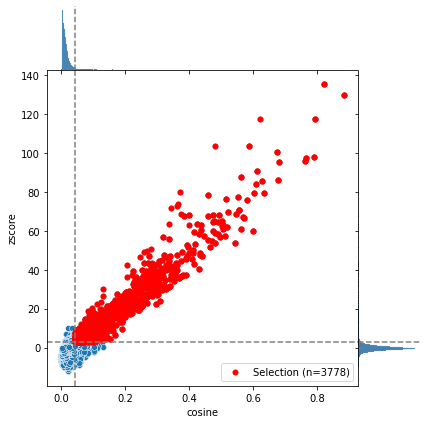

In [2]:
selection = C.select_significant_rules()

_______________

<a id="automated"></a>

## Method 1: Automated analysis

There are two different ways to run this analysis. The automated way will be shown in this chapter. Followed by an in depth guide showing the analysis step by step in the next chapter.

Here we will start with the __automated__ analysis for __all__ selected rules.  

In [3]:
selection.analyze_distances(threads=6) # adjust threads if needed

INFO: DistObject successfully created! It can be accessed via <CombObj>.distObj
INFO: Preparing to count distances.
INFO: Setting up binding sites for counting
INFO: Calculating distances
INFO: Done finding distances! Results are found in .distances
INFO: You can now run .smooth() and/or .correct_background() to preprocess sites before finding peaks.
INFO: Or you can find peaks directly using .analyze_signal_all()
INFO: Smoothing signals with window size 3
INFO: Background correction finished! Results can be found in .corrected
INFO: Analyzing Signal with threads 6
INFO: Calculating zscores for signals
INFO: Finding preferred distances
INFO: Done analyzing signal. Results are found in .peaks


In [4]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF121-ZNF770,ZNF121,ZNF770,26,4.043651,4.443567,2,1319,381,28.885519,[25;27]
ZNF121-ZNF770,ZNF121,ZNF770,58,3.906961,4.353073,2,1319,376,28.506444,[57;59]
ZNF121-ZNF770,ZNF121,ZNF770,66,2.068096,2.270661,2,1319,220,16.679303,[65;67]


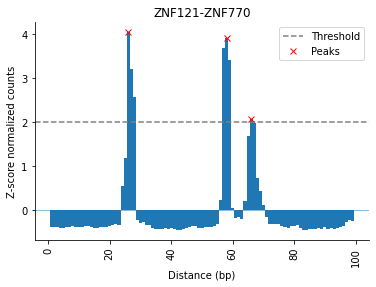

In [5]:
_ = selection.distObj.plot(("ZNF121", "ZNF770"))

On the __x-axis__ the distance in bp is shown. For example a distance of 100 means the anchors (depending on anchor mode, please refer to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. On the __y-axis__ of the plot the calculated __zscore__ per distance is shown.

For an explaination of the results please refer to the in depth guide below.

__________________

<a id="sbs"></a>

## Method 2: Step-by-Step Analysis

Besides the automated way, the analysis can be done __step-by-step__. This chapter is an detailed guide, covering all 5 major steps.

<a id="1"></a>

### 1. Create a distance object

The binding distance analysis can be started from within any _combObj_. In this example the appropiate object is called __selection__, since we only want to use __significant__ rules, not all. The analysis can also be done without pre selection.

In [6]:
selection.create_distObj()

INFO: DistObject successfully created! It can be accessed via <CombObj>.distObj


As stated in the information message, the distObj should be created successfully and filled with all important information to start the distance analysis. This includes parameters set for the market masket analysis. 

In [7]:
selection.distObj

The 3792 rules (market basket results) selected earlier by _select.significant_rules()_ are automatically passed to the distance object during creation:

In [8]:
selection.distObj.rules

,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
POU3F2-SMARCA5,POU3F2,SMARCA5,239,302,241,0.885902,129.586528
SMARCA5-POU3F2,SMARCA5,POU3F2,239,241,302,0.885902,129.586528
POU2F1-SMARCA5,POU2F1,SMARCA5,263,426,241,0.820810,135.355691
SMARCA5-POU2F1,SMARCA5,POU2F1,263,241,426,0.820810,135.355691
SMARCA5-ZNF582,SMARCA5,ZNF582,172,241,195,0.793419,117.370387
...,...,...,...,...,...,...,...
NFYB-EGR2,NFYB,EGR2,24,219,1304,0.044911,3.401991
MYOG-TAF1,MYOG,TAF1,23,386,681,0.044860,3.375730
TAF1-MYOG,TAF1,MYOG,23,681,386,0.044860,3.375730
ETV1-ZBTB17,ETV1,ZBTB17,20,117,1699,0.044858,3.064184


To unify the analysis steps between the market basket and the binding distance ones, the parameters for the: \
    1. _minimal distance_ \
    2. _maximal distance_   \
    3. _maximal allowed overlap_ \
    4. _directionality_   \
    5. _anchor_  
 
will be set automatically when creating the distance object according to the values used for the _market basket analysis_ step.

In [9]:
selection.distObj.max_overlap

0.0

<a id="2"></a>

### 2. Distance counting

After creating the distObj, the first step is to count the distances. This will be done with .count_distances().
In this step it is important to decide if the directionality should be taken into account. 

If __directionality__ is taken into account the position of the transcription factors do matter. This means there is a difference between _TFA -> TFB_ and _TFB -> TFA_ (compare [Orientation analysis](./Orientation_analysis.ipynb) notebook). Otherwise _TFA -> TFB_ and _TFB -> TFA_ are the same.
 
Per default the __directionality__ decision __is copied__ from the market basket step.

In [10]:
selection.distObj.directional

False

In [11]:
selection.distObj.count_distances()

INFO: Preparing to count distances.
INFO: Setting up binding sites for counting
INFO: Calculating distances
INFO: Done finding distances! Results are found in .distances
INFO: You can now run .smooth() and/or .correct_background() to preprocess sites before finding peaks.
INFO: Or you can find peaks directly using .analyze_signal_all()


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the distances in bp
- __rows__: each row representing one rule (pair) with the corresponding results



In [12]:
selection.distObj.distances

,TF1,TF2,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
POU3F2-SMARCA5,POU3F2,SMARCA5,2,0,0,7,0,15,0,1,...,0,0,7,1,6,0,0,3,0,3
SMARCA5-POU3F2,SMARCA5,POU3F2,2,0,0,7,0,15,0,1,...,0,0,7,1,6,0,0,3,0,3
POU2F1-SMARCA5,POU2F1,SMARCA5,0,2,0,39,0,0,12,1,...,4,0,5,0,0,4,0,1,0,1
SMARCA5-POU2F1,SMARCA5,POU2F1,0,2,0,39,0,0,12,1,...,4,0,5,0,0,4,0,1,0,1
SMARCA5-ZNF582,SMARCA5,ZNF582,0,0,38,0,36,1,1,2,...,0,4,0,2,0,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NFYB-EGR2,NFYB,EGR2,2,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
MYOG-TAF1,MYOG,TAF1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TAF1-MYOG,TAF1,MYOG,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ETV1-ZBTB17,ETV1,ZBTB17,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,1,0,0,0


### Additional options for counting distances
<a id="neg"></a>

#### Negative distances
Negative distances indicate overlapping. Caveat: this is basepair resolution and strongly dependend on motif length. \
Negative distance can occur if the distance anchor is set to _inner_ mode (see [Anchor mode](#Anchor-mode)) and overlapping is allowed. 

#### Anchor mode

TFCOMB distance analysis supports three different anchor modes: _inner_ , _outer_ and _center_. The recommended mode is __inner__. 

1. inner (default, recommented) is the distance *between* the transcription factors, it is measures as _start(transcription factor B) - end(transcription factor A)_. If for example transcription factor B is directly adjacent to Transcription factor A, the difference will be zero.
2. center is the distance measured from mid of transcription factor to mid of transcription factor
3. outer (uncommonly used) is the distance measured including both transcription factors. _end(transcription factor B) - start(transcription factor A)_

#### Directionality
Since we didn't count directional, the values for the pairs TF1-TF2 and TF2-TF1 should be equal. For example in the DataFrame above the results for _ZNF121_-_ZNF770_ are the same as for _ZNF770_-_ZNF121_. This is not true if directionality is considered. 

__Note:__ If directionality is not considered, the duplicates can be filtered with .simplify_rules()


#### Plotting
There are different ways to plot the distance distribution, you can for example create a kernel density estimate (KDE) plot or a histogram of the distribution.

<AxesSubplot:title={'center':'ZNF121-ZNF770'}, xlabel='Distance (bp)', ylabel='Count per distance'>

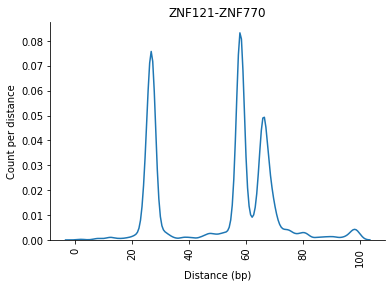

In [13]:
selection.distObj.plot(("ZNF121", "ZNF770"), style="kde")

<AxesSubplot:title={'center':'ZNF121-ZNF770'}, xlabel='Distance (bp)', ylabel='Count per distance'>

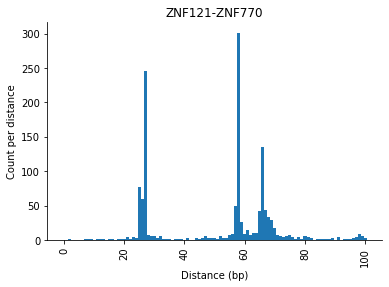

In [14]:
selection.distObj.plot(("ZNF121", "ZNF770"), style="hist")

For __both__ plots the __x-axis__ shows the distance in bp. \
<a id="dist"></a>
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
For the __y-axis__ of the __kde plot__ the density estimation is shown. \
For the __y-axis__ of the __histogram__ the counts per distance is shown.

<a id="3"></a>

### 3. Smoothing counts 

In order to collect distances from more than one basepair, e.g. in a window, it is possible to smooth the counted distances. This is done using the function .smooth() of the distObj:

In [15]:
selection.distObj.smooth(window_size=3)

INFO: Smoothing signals with window size 3


The smoothed (min-max-scaled) distances are visible in the .smoothed variable:

In [16]:
selection.distObj.smoothed.head()

,TF1,TF2,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
POU3F2-SMARCA5,POU3F2,SMARCA5,0.666667,2.333333,2.333333,7.333333,5.000000,5.333333,10.333333,10.333333,...,1.666667,1.666667,2.333333,2.666667,4.666667,2.333333,2.000000,1.000000,1.000000,2.000000
SMARCA5-POU3F2,SMARCA5,POU3F2,0.666667,2.333333,2.333333,7.333333,5.000000,5.333333,10.333333,10.333333,...,1.666667,1.666667,2.333333,2.666667,4.666667,2.333333,2.000000,1.000000,1.000000,2.000000
POU2F1-SMARCA5,POU2F1,SMARCA5,0.666667,13.666667,13.000000,13.000000,4.000000,4.333333,5.333333,1.333333,...,1.333333,1.333333,3.000000,1.666667,1.666667,1.333333,1.333333,1.666667,0.333333,0.666667
SMARCA5-POU2F1,SMARCA5,POU2F1,0.666667,13.666667,13.000000,13.000000,4.000000,4.333333,5.333333,1.333333,...,1.333333,1.333333,3.000000,1.666667,1.666667,1.333333,1.333333,1.666667,0.333333,0.666667
SMARCA5-ZNF582,SMARCA5,ZNF582,12.666667,12.666667,24.666667,12.333333,12.666667,1.333333,1.333333,3.333333,...,1.333333,1.333333,1.333333,2.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.333333


<a id="4"></a>

### 4. Scale counts (optional)

Optionally, it is possible to scale the counts to be in the same ranges regardless of number of counts per pair.

In [17]:
selection_copy = selection.copy() #create a copy to not alter the real selection object
selection_copy.distObj.scale()

In [18]:
selection_copy.distObj.scaled.head()

,TF1,TF2,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
POU3F2-SMARCA5,POU3F2,SMARCA5,0.017857,0.107143,0.107143,0.375,0.250000,0.267857,0.535714,0.535714,...,0.071429,0.071429,0.107143,0.125000,0.232143,0.107143,0.089286,0.035714,0.035714,0.089286
SMARCA5-POU3F2,SMARCA5,POU3F2,0.017857,0.107143,0.107143,0.375,0.250000,0.267857,0.535714,0.535714,...,0.071429,0.071429,0.107143,0.125000,0.232143,0.107143,0.089286,0.035714,0.035714,0.089286
POU2F1-SMARCA5,POU2F1,SMARCA5,0.025000,1.000000,0.950000,0.950,0.275000,0.300000,0.375000,0.075000,...,0.075000,0.075000,0.200000,0.100000,0.100000,0.075000,0.075000,0.100000,0.000000,0.025000
SMARCA5-POU2F1,SMARCA5,POU2F1,0.025000,1.000000,0.950000,0.950,0.275000,0.300000,0.375000,0.075000,...,0.075000,0.075000,0.200000,0.100000,0.100000,0.075000,0.075000,0.100000,0.000000,0.025000
SMARCA5-ZNF582,SMARCA5,ZNF582,0.513514,0.513514,1.000000,0.500,0.513514,0.054054,0.054054,0.135135,...,0.054054,0.054054,0.054054,0.081081,0.027027,0.027027,0.027027,0.027027,0.040541,0.013514


<a id="5"></a>

### 5. Background correction

To separate the signal from the background noise a linear regression for every signal needs to be fitted next. The result of the fitted line for every pair can be found in the .linres attribute of the distance object.

In [19]:
selection.distObj.correct_background(threads=6)

INFO: Background correction finished! Results can be found in .corrected


The fitted lowess function can be plotted with the .plot() command. The __red line__ indicates the linear regression line which was fitted during this step. 

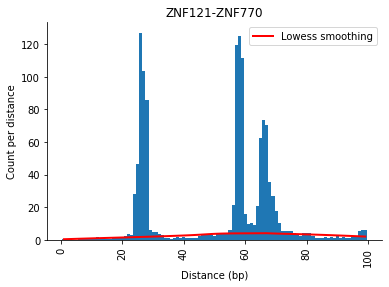

In [20]:
_ = selection.distObj.plot(("ZNF121", "ZNF770"), method="correction")

After correction, the plotting function will show the corrected counts:

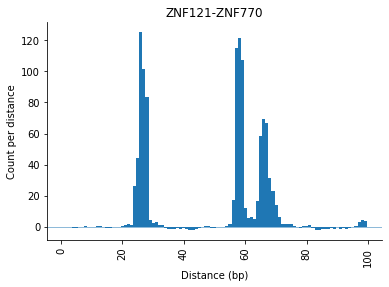

In [21]:
_ = selection.distObj.plot(("ZNF121", "ZNF770"))

<a id="6"></a>

### 6. Analyse signal 

As a last step, the corrected signal can now be analyzed. Peaks will be called with [_scipy.signal.find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). Two different methods are available: 

1. "zscore" 
2. "flat" (number)

<a id="zscore"></a>

#### Zscore method

If prominence is set to __zscore__, the threshold is set in relation to the zscore (of the corrected signal) for each signal. For example if threshold is 2, the threshold prominence (for the score translated signal) will be a zscore of two. 

In [22]:
selection.distObj.analyze_signal_all(method="zscore", threshold=2, threads=6)
selection.distObj.peaks

INFO: Analyzing Signal with threads 6
INFO: Calculating zscores for signals
INFO: Finding preferred distances
INFO: Done analyzing signal. Results are found in .peaks


,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZFP82-SMARCA5,ZFP82,SMARCA5,8,6.547058,7.582435,2,198,46,23.232323,[7;9]
SMARCA5-ZFP82,SMARCA5,ZFP82,8,6.547058,7.582435,2,198,46,23.232323,[7;9]
ZNF394-SMARCA5,ZNF394,SMARCA5,5,6.940786,7.474373,2,187,74,39.572193,[4;6]
SMARCA5-ZNF394,SMARCA5,ZNF394,5,6.940786,7.474373,2,187,74,39.572193,[4;6]
POU3F2-SMARCA5,POU3F2,SMARCA5,9,6.584317,7.402690,2,234,57,24.358974,[8;10]
...,...,...,...,...,...,...,...,...,...,...
ETV5-ZSCAN22,ETV5,ZSCAN22,98,2.010752,2.010752,2,64,3,4.687500,[97;99]
ZBTB17-RFX1,ZBTB17,RFX1,1,2.010639,2.010639,2,30,1,3.333333,[1;2]
RFX1-ZBTB17,RFX1,ZBTB17,1,2.010639,2.010639,2,30,1,3.333333,[1;2]
WT1-ZIC3,WT1,ZIC3,48,2.226574,2.005542,2,51,4,7.843137,[47;49]


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by 

    1. __Distance__ in bp \
    2. __Peak Heights__ height of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)). \
    3. __Prominences__ prominence of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)). \
    4. __Threshold__ minimum prominence needed to be considered as peak (in this example the [zscore](#5.B.-Zscore) of the signal). \
    5. __TF1_TF2_count__ is the total number of co-occurring TF1-TF2 sites. \
    6. __Distance_count__ The number of co-occurrences for the given distance. \
    7. __Distance_percent__ The percent of Distance_count of the total sites (TF1_TF2_count). \
    8. __Distance_window__ The distances collected for the given distance. Will be a window if smoothing was applied. \
    
    
- __rows__: each row representing one rule (pair) at a distinct prefered binding distance with the corresponding results

The signal and peaks can now be plotted with the .plot() command.

<AxesSubplot:title={'center':'ZNF121-ZNF770'}, xlabel='Distance (bp)', ylabel='Z-score normalized counts'>

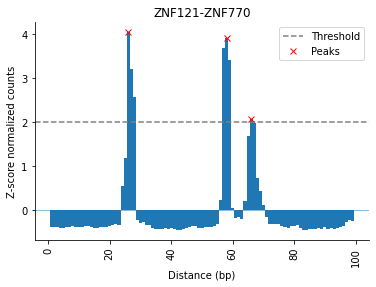

In [23]:
selection.distObj.plot(("ZNF121", "ZNF770"))

This plot shows the __corrected__ signal with the __called peaks__, indicated by a cross.


The __grey dottet line__ shows the decision boundary (in this example a zscore of 2)

In [24]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF121-ZNF770,ZNF121,ZNF770,26,4.043651,4.443567,2,1319,381,28.885519,[25;27]
ZNF121-ZNF770,ZNF121,ZNF770,58,3.906961,4.353073,2,1319,376,28.506444,[57;59]
ZNF121-ZNF770,ZNF121,ZNF770,66,2.068096,2.270661,2,1319,220,16.679303,[65;67]


The results in the .peaks table and the plot matches. For this _ZNF121_-_ZNF770_ 3 peaks were found, which also can be seen in the plot at positions: 

   1. distance: 26 
   2. distance: 58
   3. distance: 66 
    
Meaning the zscore threshold with stringency of 2 identifies 3 different preferred distances for this pair. Please note, that the height of the distances differ!

<a id="flat"></a>
#### Flat threshold

Using a flat threshold, it is possible to only find peaks with a certain number of counts as seen here:

In [25]:
selection.distObj.analyze_signal_all(method="flat", threshold=80, threads=6)
selection.distObj.peaks

INFO: Analyzing Signal with threads 6
INFO: Calculating zscores for signals
INFO: Finding preferred distances
INFO: Done analyzing signal. Results are found in .peaks


,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF121-ZNF770,ZNF121,ZNF770,26,125.175641,125.839985,80,1319,381,28.885519,[25;27]
ZNF770-ZNF121,ZNF770,ZNF121,26,125.175641,125.839985,80,1319,381,28.885519,[25;27]
ZNF121-ZNF770,ZNF121,ZNF770,58,121.304647,123.277229,80,1319,376,28.506444,[57;59]
ZNF770-ZNF121,ZNF770,ZNF121,58,121.304647,123.277229,80,1319,376,28.506444,[57;59]
PAX5-ZNF770,PAX5,ZNF770,56,104.564327,106.526327,80,896,325,36.272321,[55;57]
ZNF770-PAX5,ZNF770,PAX5,56,104.564327,106.526327,80,896,325,36.272321,[55;57]


<AxesSubplot:title={'center':'ZNF121-ZNF770'}, xlabel='Distance (bp)', ylabel='Count per distance'>

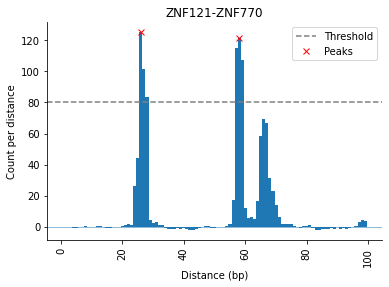

In [26]:
selection.distObj.plot(("ZNF121", "ZNF770"))

----------------

## Further downstream analysis

<a id="hubs"></a>

### 1.  Analyzing hubs

This function allows to summarize the number of different partners (with at least one peak) each transcription factor has.

In [27]:
selection.distObj.analyze_hubs().sort_values()

PAX5      1
ZNF121    1
ZNF770    2
dtype: int64

<a id="classification"></a>

### 2. Signal classification

This function allows to classify the pairs (in .distance DataFrame) wheather the signal is peaking or not.

In [28]:
selection.distObj.classify_rules()
selection.distObj.classified.sort_values(by="isPeaking")

INFO: classifying rules
INFO: classifcation done. Results can be found in .classified


,TF1,TF2,isPeaking
POU3F2-SMARCA5,POU3F2,SMARCA5,False
ELK4-WT1,ELK4,WT1,False
WT1-ELK4,WT1,ELK4,False
ELF2-SP1,ELF2,SP1,False
SP1-ELF2,SP1,ELF2,False
...,...,...,...
ZBTB17-ETV1,ZBTB17,ETV1,False
ZNF121-ZNF770,ZNF121,ZNF770,True
PAX5-ZNF770,PAX5,ZNF770,True
ZNF770-PAX5,ZNF770,PAX5,True


True means the signal has at least one peak found, False otherwise.